<a href="https://colab.research.google.com/github/edenLee94/CV/blob/main/object%20detection/iou_giou_nms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## IoU구하기-입력인자로 후보 박스와 실제 박스를 받아서 IOU를 계산하는 함수 생성

#### IOU함수 만들기 -v1.

In [ ]:
import numpy as np 

def compute_iou(cand_box, gt_box):

    # Calculate intersection areas
    x1 = np.maximum(cand_box[0], gt_box[0])
    y1 = np.maximum(cand_box[1], gt_box[1])
    x2 = np.minimum(cand_box[2], gt_box[2])
    y2 = np.minimum(cand_box[3], gt_box[3])
    
    intersection = np.maximum(x2 - x1, 0) * np.maximum(y2 - y1, 0)
    
    cand_box_area = (cand_box[2] - cand_box[0]) * (cand_box[3] - cand_box[1])
    gt_box_area = (gt_box[2] - gt_box[0]) * (gt_box[3] - gt_box[1])
    union = cand_box_area + gt_box_area - intersection
    
    iou = intersection / union
    return iou

#### IOU함수 만들기 -v2.

In [ ]:
import tensorflow as tf


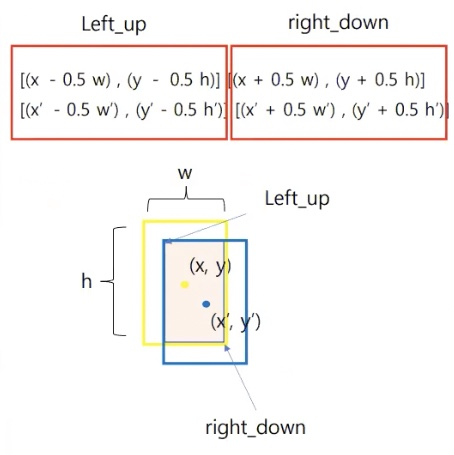



In [ ]:
def bbox_iou(boxes1, boxes2):
  boxes1_area = boxes1[..., 2] * boxes1[..., 3] # width, heigh값 -> 넓이 계산
  boxes2_area = boxes2[..., 2] * boxes2[..., 3] # width, heigh값

  boxes1 = tf.concat([boxes1[...,:2]- boxes1[...,2:] *0.5,
                      [boxes1[...,:2]- boxes1[...,2:] *0.5], axis=-1)
  boxes2 = tf.concat([boxes2[...,:2]- boxes2[...,2:] *0.5,
                      [boxes2[...,:2]- boxes2[...,2:] *0.5], axis=-1)
  left_up = tf.maximum(boxes1[...,:2], boxes2[...,:2])
  rigth_down = tf.minimum(boxes1[...,2:], boxes2[...,2:])

  inter_section = tf.maximum(right_down - left_up, 0.0) # 겹치는 부분의 내부 영역의 좌표 구하기(포함하고 있는 거 = 교집합 느낌이라고 설명할 수 있다.)
  inter_area = inter_selection[..., 0] * inter_selection[..., 1] 
  union_area = boxes1_area + boxes2_area - inter_area

  return 1.0 * inter_area / union_area

In [ ]:
!mkdir /content/data
!wget -O /content/data/audrey01.jpg https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/audrey01.jpg

--2022-07-03 18:32:25--  https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/audrey01.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30102 (29K) [image/jpeg]
Saving to: ‘/content/data/audrey01.jpg’

/content/data/audre 100%[===================>]  29.40K  --.-KB/s    in 0.001s  

2022-07-03 18:32:25 (26.7 MB/s) - ‘/content/data/audrey01.jpg’ saved [30102/30102]



### 실습을 위한 Ground Truth 박스를 정함

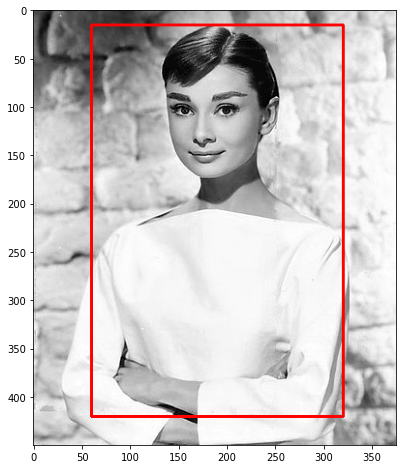

In [ ]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

# 실제 box(Ground Truth)의 좌표를 아래와 같다고 가정한다 -> (임의값으로 넣음)
gt_box = [60, 15, 320, 420] # [60-320, 15,420]

img = cv2.imread('./data/audrey01.jpg')
# cvtColor : RGB로 바꿈
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

red = (255, 0 , 0)
img_rgb = cv2.rectangle(img_rgb, (gt_box[0], gt_box[1]), (gt_box[2], gt_box[3]), color=red, thickness=2)

plt.figure(figsize=(8, 8))
plt.imshow(img_rgb)
plt.show()

In [ ]:
!pip install selectivesearch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for selectivesearch: filename=selectivesearch-0.4-py3-none-any.whl size=4349 sha256=e81c0a3b93d15f38883f6954386ff9fbe4ffd8de5b9a80f8c386a574c188f172
  Stored in directory: /root/.cache/pip/wheels/83/0e/c9/4713ec9c1692e688f84fd3e80201018a02992949ca63697ba8
Successfully built selectivesearch


### Region Proposal(후보 영역) 선택

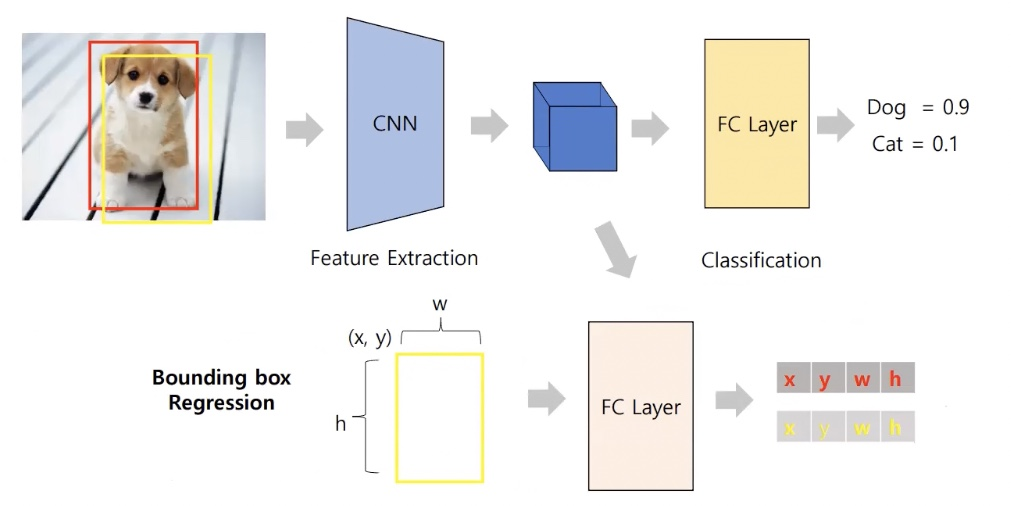

### selective search - cpu 사용한다
- 빠른 detection과 높은 recall 예측 성능을 동시에 만족하는 알고리즘
- 컬러, 무늬, 크기, 형태에 따라 유사한 region을 grouping

- 각각의 object들이 1개의 개별 영역에 담길 수 있도록 많은 초기 영역을 생성한다.
  1. 개별 segment된 모든 부분들을 bounding box로 만들어서 region proposal list 추가
  2. 컬러 무늬, 크기, 형태에 따라 유사도가 비슷한 segment들을 grouping
  3. 다시 1번 step region proposal 리스트 추가
  4. 유사도가 비슷한 segmentemf grouping을 계속 반복하면서 region proposal 수행

### Edge boxes

In [ ]:
import selectivesearch

#selectivesearch.selective_search()는 이미지의 Region Proposal정보를 반환 
_, regions = selectivesearch.selective_search(img_rgb, scale=100, min_size=2000)

print(type(regions), len(regions))

<class 'list'> 53


### IoU값 구하기
rect만 뽑아내어 너비와 높이를 계산하고, 위에서 만든 iou함수에 값을 전달하여 iou값을 구한다

https://gaussian37.github.io/math-algorithm-iou/

In [ ]:
cand_rects = [cand['rect'] for cand in regions]
for index, cand_box in enumerate(cand_rects):
    cand_box = list(cand_box)
    cand_box[2] += cand_box[0] #너비
    cand_box[3] += cand_box[1] #높이
    
    iou = compute_iou(cand_box, gt_box)
    print('index:', index, "iou:", iou)

index: 0 iou: 0.0
index: 1 iou: 0.0713319505816575
index: 2 iou: 0.1134453781512605
index: 3 iou: 0.9874899187876287
index: 4 iou: 0.9748907882241216
index: 5 iou: 0.09851851851851852
index: 6 iou: 0.04228869895536562
index: 7 iou: 0.15042735042735042
index: 8 iou: 0.14541310541310543
index: 9 iou: 0.10112060778727446
index: 10 iou: 0.1194681861348528
index: 11 iou: 0.14017094017094017
index: 12 iou: 0.0
index: 13 iou: 0.0
index: 14 iou: 0.5933903133903133
index: 15 iou: 0.0
index: 16 iou: 0.0853656220322887
index: 17 iou: 0.12535612535612536
index: 18 iou: 0.0
index: 19 iou: 0.1498762283399595
index: 20 iou: 0.0
index: 21 iou: 0.05242165242165242
index: 22 iou: 0.0
index: 23 iou: 0.050123456790123457
index: 24 iou: 0.07313390313390314
index: 25 iou: 0.009348810110697799
index: 26 iou: 0.0
index: 27 iou: 0.23817663817663817
index: 28 iou: 0.18719489628676664
index: 29 iou: 0.19555555555555557
index: 30 iou: 0.20454890788224123
index: 31 iou: 0.0
index: 32 iou: 0.5958024691358025
index:

In [ ]:
cand_rects = [cand['rect'] for cand in regions if cand['size'] > 5000]
cand_rects.sort()
cand_rects

[(0, 0, 58, 257),
 (0, 0, 58, 266),
 (0, 0, 58, 266),
 (0, 0, 171, 449),
 (0, 0, 195, 449),
 (0, 0, 374, 449),
 (0, 0, 374, 449),
 (0, 0, 374, 449),
 (0, 256, 57, 188),
 (0, 256, 171, 193),
 (16, 0, 270, 50),
 (16, 0, 270, 109),
 (16, 0, 270, 199),
 (16, 0, 302, 418),
 (62, 17, 256, 401),
 (63, 0, 311, 449),
 (63, 18, 114, 91),
 (63, 91, 120, 123),
 (63, 91, 132, 220),
 (63, 171, 254, 246),
 (63, 171, 254, 247),
 (63, 171, 254, 247),
 (63, 171, 311, 278),
 (84, 313, 290, 136),
 (84, 360, 290, 89),
 (84, 360, 290, 89),
 (134, 18, 119, 181),
 (136, 23, 117, 176),
 (153, 366, 151, 51),
 (166, 23, 87, 176),
 (197, 0, 177, 420),
 (197, 18, 120, 132),
 (197, 18, 120, 209),
 (232, 79, 85, 148),
 (284, 0, 90, 420),
 (284, 0, 90, 420),
 (284, 0, 90, 420),
 (323, 105, 51, 248)]

In [ ]:
import os

img shape: (450, 375, 3)
index: 3 iou: 0.9874899187876287 rectangle: (59, 14, 321, 421)
index: 4 iou: 0.9748907882241216 rectangle: (62, 17, 318, 418)
index: 12 iou: 0.5933903133903133 rectangle: (63, 171, 317, 417)
index: 27 iou: 0.5958024691358025 rectangle: (63, 171, 317, 418)
index: 30 iou: 0.5958024691358025 rectangle: (63, 171, 317, 418)
index: 42 iou: 0.5008648690956052 rectangle: (63, 171, 374, 449)
index: 43 iou: 0.7389566501483806 rectangle: (63, 0, 374, 449)
index: 44 iou: 0.815085997397344 rectangle: (16, 0, 318, 418)
index: 45 iou: 0.6270619201314865 rectangle: (0, 0, 374, 449)
index: 46 iou: 0.6270619201314865 rectangle: (0, 0, 374, 449)
index: 47 iou: 0.6270619201314865 rectangle: (0, 0, 374, 449)


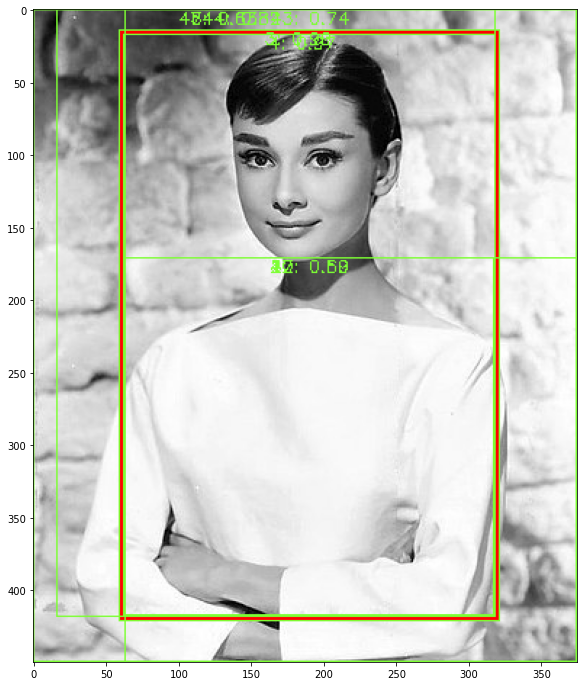

In [ ]:
img = cv2.imread('./data/audrey01.jpg')
# cvtColor : RGB로 바꿈
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print('img shape:', img.shape)

green_rgb = (125, 255, 51)
cand_rects = [cand['rect'] for cand in regions if cand['size'] > 3000]
gt_box = [60, 15, 320, 420]
img_rgb = cv2.rectangle(img_rgb, (gt_box[0], gt_box[1]), (gt_box[2], gt_box[3]), color=red, thickness=2)

for index, cand_box in enumerate(cand_rects):
    
    cand_box = list(cand_box)
    cand_box[2] += cand_box[0]
    cand_box[3] += cand_box[1]
    
    iou = compute_iou(cand_box, gt_box)
    
    if iou > 0.5:
        print('index:', index, "iou:", iou, 'rectangle:',(cand_box[0], cand_box[1], cand_box[2], cand_box[3]) )
        cv2.rectangle(img_rgb, (cand_box[0], cand_box[1]), (cand_box[2], cand_box[3]), color=green_rgb, thickness=1)
        text = "{}: {:.2f}".format(index, iou)
        cv2.putText(img_rgb, text, (cand_box[0]+ 100, cand_box[1]+10), cv2.FONT_HERSHEY_SIMPLEX, 0.4, color=green_rgb, thickness=1)
    
plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)
plt.show()

처음에 그림을 가져오고, 그림을 출력한다

빨간색으로 실제 영역을 표시한다(임의값으로 인물을 잡음)

사이즈가 3000이상인 후보 박스들의 값을 보면서 iou값을 계산한다

iou값이 0.5이상이면 초록색으로 해당 후보 박스를 그린다

## gIOU
Generalized IOU
- 두 box간 교집합이 없으면, IOU는 0이 되므로 얼마나 오차가 있었는지 알기 어려운 점을 보완한 지표

=> 어느 정도까지 틀렸는지 확인할 수 있는거를 커버할 수 있게 IOU로 결과를 받으면 알 수 없는 수치를 알기 위해서 

1) A, B box는 거리가 비교적 좀 많이 멀리 존재한다. -> error값이 높다.

2) C, D box는 거리가 1)과 비교적 가깝게 설정되어있다. 그렇다면, 1번보다 error가 낮다. -> 조금만 업데이트하면 된다.

In [ ]:
def bbox_giou(boxes1, boxes2):
  boxes1 = tf.concat([boxes1[..., :2] * boxes1[..., 2:] *0.5,
                     [boxes1[..., :2] - boxes1[...,2:] *0.5], axis=-1)
  boxes2 = tf.concat([boxes2[...,:2]- boxes2[...,2:] *0.5,
                      [boxes2[...,:2]- boxes2[...,2:] *0.5], axis=-1)
  
  boxes1 = tf.concat([tf.minimum(boxes1[..., :2], boxes1[..., :2]),
                      tf.maximum(boxes1[..., :2], boxes1[..., 2:])], axis=-1)
  boxes2 = tf.concat([tf.minimum(boxes2[..., :2], boxes2[..., :2]),
                      tf.maximum(boxes2[..., :2], boxes2[..., 2:])], axis=-1)

  boxes1_area = (boxes1[..., 2] - boxes1[..., 0]) * (boxes1[..., 3] * boxes1[..., 1])
  boxes2_area = (boxes2[..., 2] - boxes2[..., 0]) * (boxes2[..., 3] * boxes2[..., 1])

  left_up = tf.maximum(boxes1[...,:2], boxes2[...,:2])
  rigth_down = tf.minimum(boxes1[...,2:], boxes2[...,2:])

  inter_section = tf.maximum(right_down - left_up, 0.0) # 겹치는 부분의 내부 영역의 좌표 구하기(포함하고 있는 거 = 교집합 느낌이라고 설명할 수 있다.)
  inter_area = inter_selection[..., 0] * inter_selection[..., 1] 
  union_area = boxes1_area + boxes2_area - inter_area # 합집합 크기

  enclose_left_up = tf.minimum(boxes1[...,:2], boxes2[...,:2])
  enclose_right_down = tf.maximum(boxes1[...,2:], boxes2[...,2:])
  enclose = tf.maximum(enclose_right_down - enclose_left_up, 0.0)
  enclose_area = enclose[..., 0] * enclose[..., 1] # GT와 prediction을 포괄하는 가장 작은 박스
  giou = iou - 1.0* (enclose_area - union_area) / enclose_area
 
  return giou

## NMS

In [ ]:
def nms(bboxes, iou_threshold, sigma=0.3):
  classes_in_img = list(set(bboxes[:,5])) # 5번째 index에 있는 값을 가지고 온다. - class! (object들 class ex.car, dog, cat..)
                        # set함수를 통해서 집합으로 만든다(순서 상관 x)
  best_bboxes = [] # return할 bound box!

  for cis in classes_in_img: # object별로 진행하기 위해서
    cls_mask = (bboxes[:,5]==cls) # 우선, object class = 0에 해당하는 것만 저장
    cls_bboxes = bboxes[cls_mask]
    while len(cls_bboxes) > 0:

      max_ind = np.argmax(cls_bboxes[:,4]) # score column -> 제일 큰 값
      best_bbox = cls_bboxes[max_ind]
      best_bboxes.append(best_bbox) # 추가
      cls_bboxes = np.concatenate([cls_bboxes[:max_ind], cls_bboxes[max_ind + 1:]]) 
      # best box를 빼고, 나머지 내용은 합친다.

      iou = bboxes_iou(best_bbox[np.newaxis, :4], cls_bboxes[:,:4]) 
      # 전에 정의한 bboxes_iou함수를 통해서 max를 제외한 cls_bboxes의 bound box 갯수만큼 벡터로 나온다.
      weight = np.ones((len(iou), ), dtype=np.float32) # iou의 갯수만큼 1값을 채워서 만든다.

      iou_mask = iou > iou_threshold # iou_threshold =0.4를 주어졌다면, 그 값보다 큰 값들을 true
      weight[iou_mask] =0.0 # 큰 값들을 제거해주기 위해서 이렇게 저장해둔다. -> why? 겹치기 때문에 

      cls_bboxes[:,4] = cls_bboxes[:,4] * weight
      score_mask = cls_bboxes[:,4] > 0.
      cls_bboxes = cls_bboxes[score_mask]

    return best_bboxes